# **HW2-P1: VAE and BetaVAE**

## **1. Setup and Imports**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List, Tuple
from tqdm.notebook import tqdm

device = torch.device('mps' if torch.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [2]:
def set_seed(seed: int = 42):
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)

## **2. Dataset: Fashion-MNIST**

We will use the Fashion-MNIST dataset:

- 28×28 grayscale images
- 10 classes (e.g., T-shirt, trouser, pullover, dress, etc.)
- We will normalize pixel values to $[0, 1]$ and model them either with a **Bernoulli** (BCE) or **Gaussian** (MSE) observation model.

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),  # [0, 1]
])

train_dataset_full = datasets.FashionMNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

test_dataset = datasets.FashionMNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

In [4]:
# Create a small validation split from train
val_size = 5000
train_size = len(train_dataset_full) - val_size
train_dataset, val_dataset = random_split(train_dataset_full, [train_size, val_size])

batch_size = 128

In [5]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

len(train_dataset), len(val_dataset), len(test_dataset)

(55000, 5000, 10000)

### Quick Visual Sanity Check

In [6]:
def show_batch(batch_images, batch_labels, n=16):
    imgs = batch_images[:n].cpu().numpy()
    labels = batch_labels[:n].cpu().numpy()
    cols = int(np.sqrt(n))
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(1.5 * cols, 1.5 * rows))

    for i in range(n):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(imgs[i, 0], cmap='gray')
        plt.axis('off')
        plt.title(str(labels[i]), fontsize=8)

    plt.tight_layout()
    plt.show()

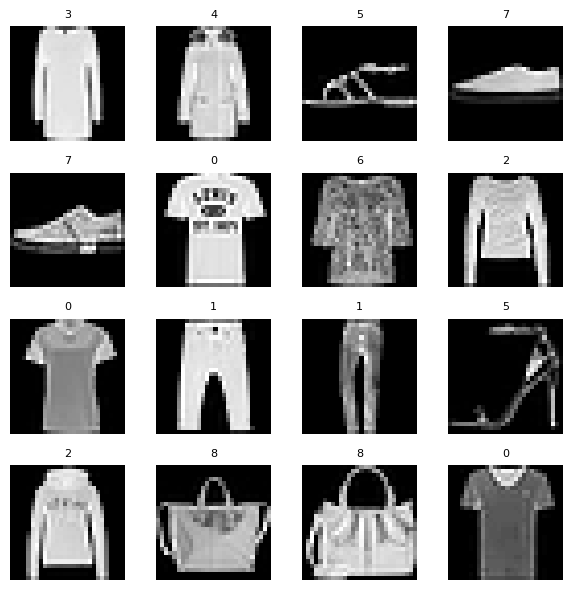

In [7]:
example_batch = next(iter(train_loader))
show_batch(*example_batch, n=16)

## **3. Implementing a VAE in PyTorch**

We implement a **fully-connected VAE** that operates on flattened 28×28 images (dimension 784).

- The encoder maps $x$ to parameters $\mu(x), \log \sigma^2(x)$ of a diagonal Gaussian $q_\phi(z \mid x)$.
- We apply the **reparameterization trick**: $z = \mu + \sigma \odot \epsilon$, with $\epsilon \sim \mathcal{N}(0, I)$.
- The decoder maps $z$ back to an image (logits for Bernoulli observation model).
- The loss is **negative ELBO**:

$$
\mathcal{L}(x) = \mathbb{E}_{q_\phi(z \mid x)}[-\log p_\theta(x \mid z)] + \mathrm{KL}(q_\phi(z \mid x) \Vert p(z))
$$

with $p(z) = \mathcal{N}(0, I)$.

In [8]:
class VAE(nn.Module):
    def __init__(self, input_dim: int = 28 * 28, latent_dim: int = 16, hidden_dim: int = 512,
                 observation_model: str = 'bernoulli'):
        """Basic VAE with a fully-connected encoder/decoder.

        Args:
            input_dim: Flattened input dimension (default 28*28 for Fashion-MNIST).
            latent_dim: Dimension of the latent space z.
            hidden_dim: Hidden layer size for encoder/decoder.
            observation_model: 'bernoulli' (BCE with logits) or 'gaussian' (MSE).
        """
        super().__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim

        assert observation_model in {'bernoulli', 'gaussian'}
        self.observation_model = observation_model

        # Encoder: x -> hidden -> (mu, logvar)
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.mu_layer = nn.Linear(hidden_dim, latent_dim)
        self.logvar_layer = nn.Linear(hidden_dim, latent_dim)

        # Decoder: z -> hidden -> reconstruction (logits or mean)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
        )

    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Encode a batch of inputs x into the parameters of q(z|x).

        Input:
            x: Tensor of shape (batch_size, input_dim), flattened images in [0, 1].

        Output:
            mu: Mean of the approximate posterior q(z|x), shape (batch_size, latent_dim).
            logvar: Log-variance of q(z|x), shape (batch_size, latent_dim).
        """
        h = self.encoder(x)
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)

        return mu, logvar

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        """Sample latent variables z using the reparameterization trick.

        Input:
            mu: Mean of q(z|x), shape (batch_size, latent_dim).
            logvar: Log-variance of q(z|x), shape (batch_size, latent_dim).

        Output:
            z: Latent samples, shape (batch_size, latent_dim).
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        """Decode latent variables z back to image space.

        Input:
            z: Latent codes, shape (batch_size, latent_dim).

        Output:
            recon: For 'bernoulli' observation_model, unnormalized logits for each pixel.
                   For 'gaussian', the predicted mean for each pixel.
                   Shape is (batch_size, input_dim).
        """
        return self.decoder(z)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Full VAE forward pass.

        Steps:
            1. Flatten the input images x.
            2. Encode to get mu(x) and logvar(x).
            3. Sample z using the reparameterization trick.
            4. Decode z to get reconstruction.

        Input:
            x: Batch of images, shape (batch_size, 1, 28, 28).

        Output:
            recon: Decoder output (logits or mean), shape (batch_size, input_dim).
            mu: Mean of q(z|x), shape (batch_size, latent_dim).
            logvar: Log-variance of q(z|x), shape (batch_size, latent_dim).
        """
        x_flat = x.view(x.size(0), -1)
        mu, logvar = self.encode(x_flat)
        z = self.reparameterize(mu, logvar)
        recon_logits_or_mean = self.decode(z)

        return recon_logits_or_mean, mu, logvar

    def kl_divergence(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        """Compute KL(q(z|x) || p(z)) for diagonal Gaussians with p(z) = N(0, I).

        Input:
            mu: Mean of q(z|x), shape (batch_size, latent_dim).
            logvar: Log-variance of q(z|x), shape (batch_size, latent_dim).

        Output:
            kl: Per-example KL, shape (batch_size,).
        """
        kl = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())
        return torch.sum(kl, dim=1)

    def reconstruction_loss(self, x: torch.Tensor, recon: torch.Tensor) -> torch.Tensor:
        """Compute the per-example reconstruction loss.

        Input:
            x: Original images, shape (batch_size, 1, 28, 28).
            recon: Decoder outputs of shape (batch_size, input_dim).
                   For 'bernoulli', these are logits.
                   For 'gaussian', these are means in [0, 1] (after sigmoid).

        Output:
            recon_loss: Per-example reconstruction cost, shape (batch_size,),
                        summed over all pixels.
        """
        x_flat = x.view(x.size(0), -1)

        if self.observation_model == 'bernoulli':
            # recon are logits -> use BCE with logits
            bce = F.binary_cross_entropy_with_logits(
                recon, x_flat, reduction='none')
            # sum over pixels
            return torch.sum(bce, dim=1)
        elif self.observation_model == 'gaussian':
            # recon is mean -> assume fixed variance; MSE up to constant
            mse = F.mse_loss(torch.sigmoid(recon), x_flat, reduction='none')
            return torch.sum(mse, dim=1)
        else:
            raise ValueError(
                f'Unknown observation model: {self.observation_model}')

    def compute_loss(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Compute the (negative) ELBO loss components for a batch.

        Steps:
            1. Run the forward pass to obtain recon, mu, logvar.
            2. Compute the per-example reconstruction loss.
            3. Compute the per-example KL divergence.
            4. Combine them as: total = recon_loss + KL.
            5. Return the mean of each loss over the batch.

        Input:
            x: Batch of images, shape (batch_size, 1, 28, 28).

        Output:
            total_loss: Scalar mean of recon + KL.
            recon_loss: Scalar mean reconstruction loss.
            kl: Scalar mean KL term.
        """
        recon, mu, logvar = self.forward(x)
        recon_loss = self.reconstruction_loss(x, recon)
        kl = self.kl_divergence(mu, logvar)
        total = recon_loss + kl

        # return mean losses over batch
        return total.mean(), recon_loss.mean(), kl.mean()

## **4. $\beta$-VAE: Re-weighting the KL term**

A **$\beta$-VAE** simply changes the relative weight of the KL term in the ELBO:

$$
\mathcal{L}_\beta(x) = \mathbb{E}_{q_\phi(z \mid x)}[-\log p_\theta(x \mid z)] + \beta \cdot \mathrm{KL}(q_\phi(z \mid x) \Vert p(z)).
$$

We implement **$\beta$-VAE** as a subclass of our `VAE` that stores a `beta` value and uses it in `compute_loss`.

In [9]:
class BetaVAE(VAE):
    def __init__(self, beta: float = 1.0, **kwargs):
        """β-VAE that re-weights the KL term by a constant β.

        Args:
            beta: KL weight. β = 1 recovers the standard VAE.
            **kwargs: Passed through to the base VAE (input_dim, latent_dim, etc.).
        """
        super().__init__(**kwargs)
        self.beta = beta

    def compute_loss(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Compute the β-VAE loss for a batch of inputs.

        This method is similar to `VAE.compute_loss`, but it always uses
        `self.beta` as the weight on the KL term.

        Steps:
            1. Run the VAE forward pass (recon, mu, logvar).
            2. Compute reconstruction_loss(x, recon).
            3. Compute KL using kl_divergence(mu, logvar).
            4. Combine as total = recon_loss + self.beta * KL.
            5. Return mean total, mean recon, mean KL.
        """
        recon, mu, logvar = self.forward(x)
        recon_loss = self.reconstruction_loss(x, recon)
        kl = self.kl_divergence(mu, logvar)
        total = recon_loss + self.beta * kl

        return total.mean(), recon_loss.mean(), kl.mean()

## **5. Training Utilities**

We now define generic training and evaluation loops that work for both `VAE` and `BetaVAE`.

We will track:
- total loss (negative ELBO)
- reconstruction loss
- KL divergence

In [10]:
def train_epoch(model: nn.Module,
                dataloader: DataLoader,
                optimizer: torch.optim.Optimizer,
                device: torch.device) -> Dict[str, float]:
    model.train()
    total_loss_sum = 0.0
    recon_loss_sum = 0.0
    kl_loss_sum = 0.0
    n = 0

    for x, _ in dataloader:
        x = x.to(device)
        optimizer.zero_grad()

        total_loss, recon_loss, kl_loss = model.compute_loss(x)
        total_loss.backward()
        optimizer.step()

        current_batch_size = x.size(0)
        total_loss_sum += total_loss.item() * current_batch_size
        recon_loss_sum += recon_loss.item() * current_batch_size
        kl_loss_sum += kl_loss.item() * current_batch_size
        n += current_batch_size

    return {
        'total': total_loss_sum / n,
        'recon': recon_loss_sum / n,
        'kl': kl_loss_sum / n
    }


@torch.no_grad()
def eval_epoch(model: nn.Module,
               dataloader: DataLoader,
               device: torch.device) -> Dict[str, float]:
    model.eval()
    total_loss_sum = 0.0
    recon_loss_sum = 0.0
    kl_loss_sum = 0.0
    n = 0

    for x, _ in dataloader:
        x = x.to(device)

        total_loss, recon_loss, kl_loss = model.compute_loss(x)
        current_batch_size = x.size(0)
        total_loss_sum += total_loss.item() * current_batch_size
        recon_loss_sum += recon_loss.item() * current_batch_size
        kl_loss_sum += kl_loss.item() * current_batch_size
        n += current_batch_size

    return {
        'total': total_loss_sum / n,
        'recon': recon_loss_sum / n,
        'kl': kl_loss_sum / n
    }


def train_model(model: nn.Module,
                train_loader: DataLoader,
                val_loader: DataLoader,
                num_epochs: int = 10,
                lr: float = 1e-3,
                device: torch.device = device
               ) -> Dict[str, List[float]]:
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {
        'train_total': [],
        'train_recon': [],
        'train_kl': [],
        'val_total': [],
        'val_recon': [],
        'val_kl': []
    }

    for epoch in range(1, num_epochs + 1):
        train_stats = train_epoch(model, train_loader, optimizer, device)
        val_stats = eval_epoch(model, val_loader, device)

        history['train_total'].append(train_stats['total'])
        history['train_recon'].append(train_stats['recon'])
        history['train_kl'].append(train_stats['kl'])
        history['val_total'].append(val_stats['total'])
        history['val_recon'].append(val_stats['recon'])
        history['val_kl'].append(val_stats['kl'])

        print(f"Epoch {epoch:02d} | "
              f"train_total={train_stats['total']:.2f} "
              f"train_recon={train_stats['recon']:.2f} "
              f"train_kl={train_stats['kl']:.2f} | "
              f"val_total={val_stats['total']:.2f} "
              f"val_recon={val_stats['recon']:.2f} "
              f"val_kl={val_stats['kl']:.2f}")

    return history

## **6. Visualization Utilities**

To **qualitatively** assess model behavior, we define:

- `plot_history`: loss curves over epochs.
- `show_reconstructions`: original vs reconstructed images.
- `sample_from_prior`: random samples from $p(z) = \mathcal{N}(0, I)$.
- `latent_interpolation`: interpolate between two encoded images in latent space.

In [18]:
def plot_history(history: Dict[str, List[float]], title: str = ''):
    epochs = range(1, len(history['train_total']) + 1)
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_total'], label='train')
    plt.plot(epochs, history['val_total'], label='val')
    plt.title('Total loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['train_recon'], label='train')
    plt.plot(epochs, history['val_recon'], label='val')
    plt.title('Reconstruction loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(epochs, history['train_kl'], label='train')
    plt.plot(epochs, history['val_kl'], label='val')
    plt.title('KL divergence')
    plt.xlabel('Epoch')
    plt.legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


@torch.no_grad()
def show_reconstructions(model: VAE,
                         dataloader: DataLoader,
                         device: torch.device,
                         n: int = 8):
    model.eval()
    x, y = next(iter(dataloader))
    x = x.to(device)
    recon, _, _ = model(x)
    recon = torch.sigmoid(recon).view(-1, 1, 28, 28)

    x = x.cpu()  # Move to CPU
    recon = recon.cpu()  # Move to CPU
    n = min(n, x.size(0))

    plt.figure(figsize=(2*n, 4))
    for i in range(n):
        # original
        plt.subplot(2, n, i+1)
        plt.imshow(x[i, 0], cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.ylabel('orig', fontsize=10)

        # reconstruction
        plt.subplot(2, n, n + i + 1)
        plt.imshow(recon[i, 0], cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.ylabel('recon', fontsize=10)

    plt.tight_layout()
    plt.show()


@torch.no_grad()
def sample_from_prior(model: VAE,
                      n: int = 16,
                      device: torch.device = device):
    """Sample from the prior p(z) = N(0, I) and visualize decoded images.

    Steps:
        1. Set the model to evaluation mode.
        2. Sample n latent vectors z ~ N(0, I) of shape (n, latent_dim) on the given device.
        3. Decode z using model.decode to obtain image logits.
        4. Apply sigmoid to map logits to pixel values in [0, 1].
        5. Reshape the decoded images to (n, 1, 28, 28).
        6. Arrange the n images in a roughly square grid using matplotlib.
        7. Display the grid of generated samples.

    Input:
        model: Trained VAE/BetaVAE model with a latent_dim attribute and decode method.
        n: Number of samples to draw from the prior and visualize.
        device: torch.device on which to sample z and run the decoder.

    Returns:
        None. The function displays a matplotlib figure of generated samples.
    """
    model.eval()
    z = torch.randn(n, model.latent_dim, device=device)
    recon_logits = model.decode(z)
    recon = torch.sigmoid(recon_logits).view(n, 1, 28, 28)
    recon = recon.cpu()  # Move to CPU before plotting

    cols = int(np.sqrt(n))
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(1.5*cols, 1.5*rows))
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        plt.imshow(recon[i, 0], cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


@torch.no_grad()
def latent_interpolation(model: VAE,
                         dataloader: DataLoader,
                         device: torch.device,
                         steps: int = 8):
    """Interpolate between two images in latent space and visualize the path.

    Steps:
        1. Set the model to evaluation mode.
        2. Take the first batch from the dataloader and move it to the given device.
        3. Flatten the images and encode them to obtain (mu, logvar).
        4. Select the first two latent means mu[0] and mu[1] as endpoints z0 and z1.
        5. Create a sequence of interpolation coefficients t in [0, 1] with length = steps.
        6. For each t, compute z_t = (1 - t) * z0 + t * z1 and collect all z_t.
        7. Decode the stacked latent codes with model.decode.
        8. Apply sigmoid and reshape to (steps, 1, 28, 28).
        9. Plot the decoded images in a single row, labeling each with its t value.
       10. Display the interpolation figure.

    Input:
        model: Trained VAE/BetaVAE model with encode and decode methods.
        dataloader: DataLoader providing batches of input images.
        device: torch.device used for encoding and decoding.
        steps: Number of interpolation points (including the two endpoints).

    Returns:
        None. The function displays a matplotlib figure of the interpolation sequence.
    """
    model.eval()
    x, y = next(iter(dataloader))
    x = x.to(device)
    x_flat = x.view(x.size(0), -1)
    mu, logvar = model.encode(x_flat)

    z0 = mu[0]
    z1 = mu[1]

    t_values = torch.linspace(0, 1, steps, device=device)
    z_interpolated = torch.stack([(1 - t) * z0 + t * z1 for t in t_values])

    recon_logits = model.decode(z_interpolated)
    recon = torch.sigmoid(recon_logits).view(steps, 1, 28, 28)
    recon = recon.cpu()  # Move to CPU before plotting

    plt.figure(figsize=(1.5*steps, 3))
    for i in range(steps):
        plt.subplot(1, steps, i+1)
        plt.imshow(recon[i, 0], cmap='gray')
        plt.axis('off')
        plt.title(f'{i/(steps-1):.2f}', fontsize=8)

    plt.tight_layout()
    plt.show()

## **7. Experiment 1: Effect of $\beta$ ($\beta$ sweep)**

We now:

1. Train several $\beta$-VAEs with different $\beta$ values (e.g., 0.5, 1, 4).
2. Plot the training curves.
3. Visualize reconstructions and prior samples.

This illustrates the **disentanglement vs fidelity** trade-off.

In [ ]:
betas = [0.5, 1.0, 4.0]
num_epochs = 10  # increase this for better convergence

beta_histories = {}
beta_models = {}

progress_bar = tqdm(betas)
for i, beta in enumerate(progress_bar):
    print('\n' + '='*50)
    print(f'Training BetaVAE with beta={beta}')
    print('='*50)

    set_seed(SEED + i)
    model = BetaVAE(beta=beta, input_dim=28*28,
                    latent_dim=16, hidden_dim=512).to(device)

    history = train_model(model, train_loader, val_loader,
                          num_epochs, device=device)
    beta_histories[beta] = history
    beta_models[beta] = model

  0%|          | 0/3 [00:00<?, ?it/s]


Training BetaVAE with beta=0.5
Epoch 01 | train_total=279.50 train_recon=272.69 train_kl=13.62 | val_total=251.68 val_recon=244.48 val_kl=14.40
Epoch 02 | train_total=246.11 train_recon=239.17 train_kl=13.88 | val_total=244.08 val_recon=236.93 val_kl=14.29
Epoch 03 | train_total=240.38 train_recon=233.04 train_kl=14.68 | val_total=239.69 val_recon=232.33 val_kl=14.72
Epoch 04 | train_total=237.53 train_recon=229.97 train_kl=15.11 | val_total=238.37 val_recon=231.03 val_kl=14.69
Epoch 05 | train_total=235.79 train_recon=228.15 train_kl=15.29 | val_total=236.32 val_recon=228.52 val_kl=15.59
Epoch 06 | train_total=234.72 train_recon=226.98 train_kl=15.46 | val_total=235.26 val_recon=227.65 val_kl=15.21
Epoch 07 | train_total=233.84 train_recon=226.02 train_kl=15.64 | val_total=234.22 val_recon=226.35 val_kl=15.75
Epoch 08 | train_total=233.08 train_recon=225.15 train_kl=15.86 | val_total=233.64 val_recon=225.58 val_kl=16.11
Epoch 09 | train_total=232.47 train_recon=224.41 train_kl=16.11 

β = 0.5


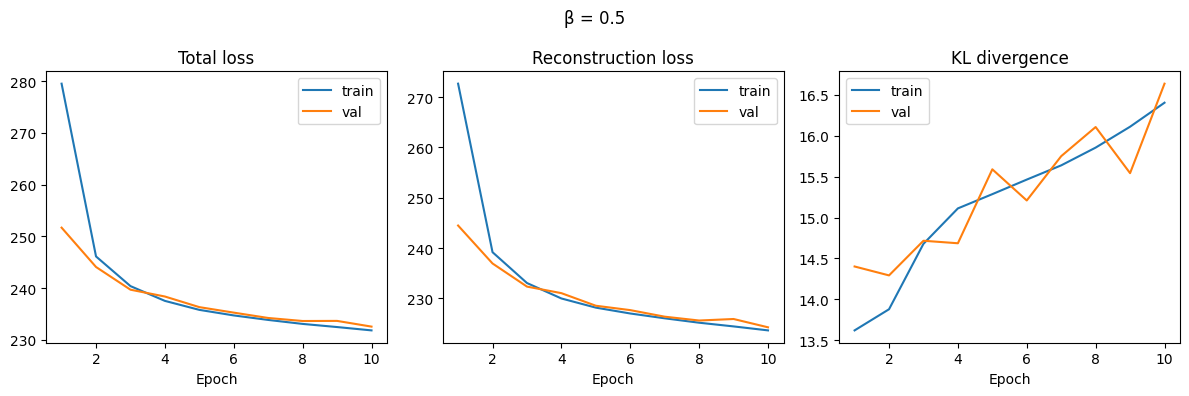

β = 1.0


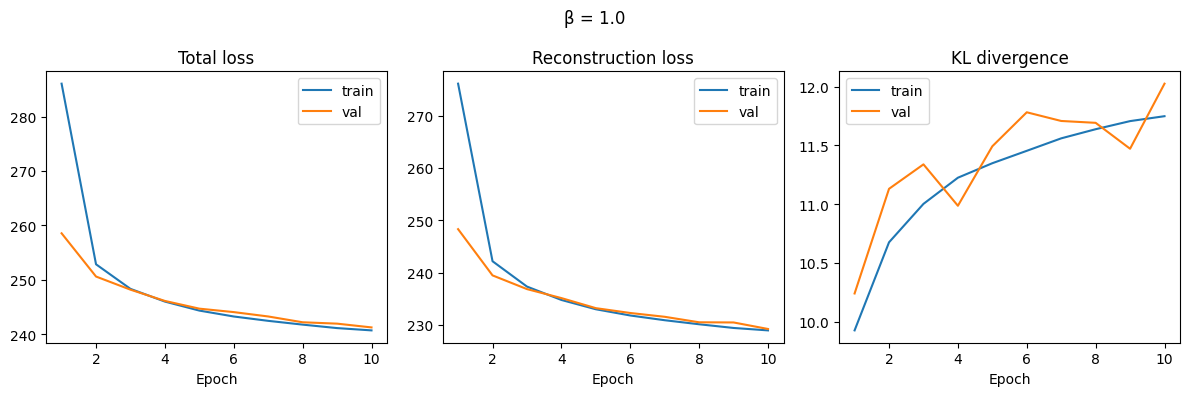

β = 4.0


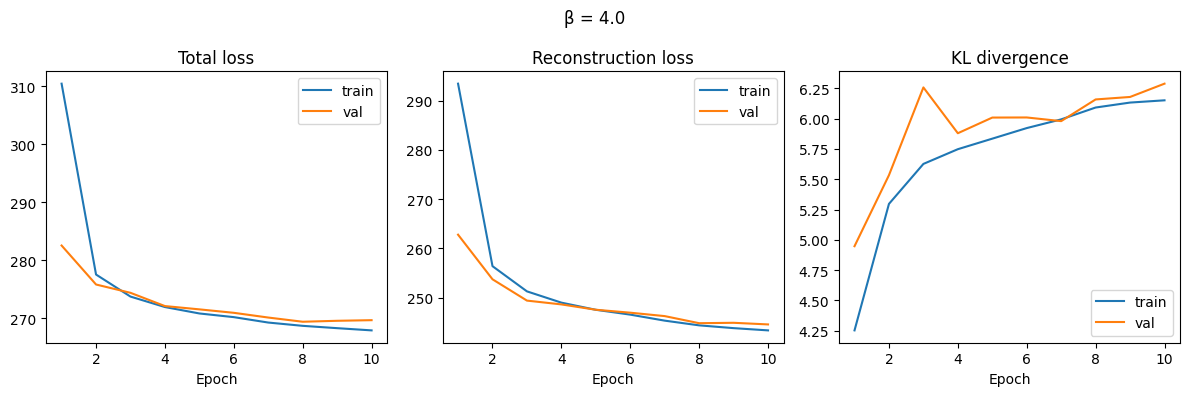

In [15]:
# Plot loss curves for each beta
for beta in betas:
    print(f'β = {beta}')
    plot_history(beta_histories[beta], title=f'β = {beta}')

β = 0.5: reconstructions


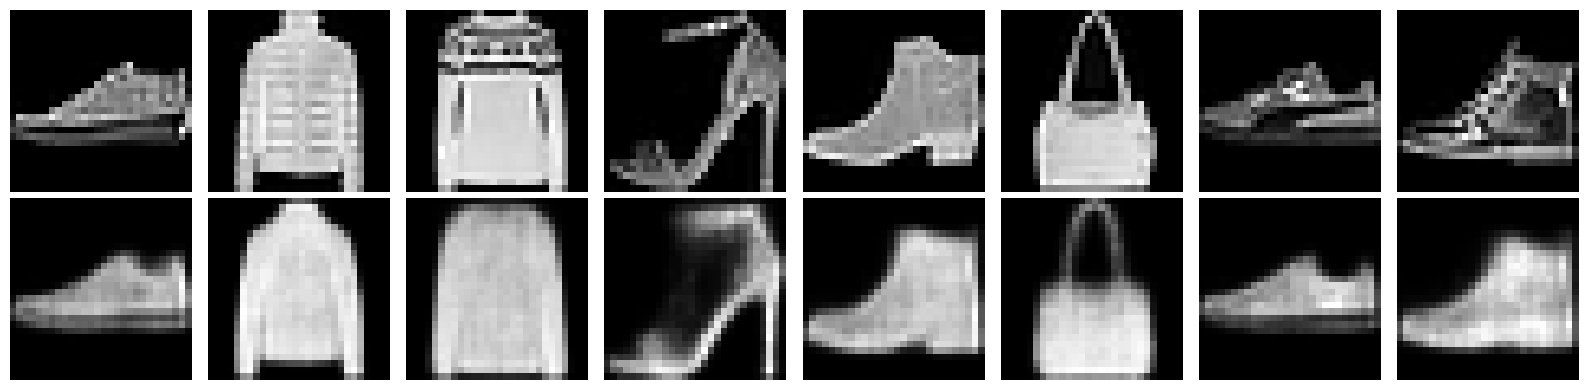

β = 0.5: samples from prior


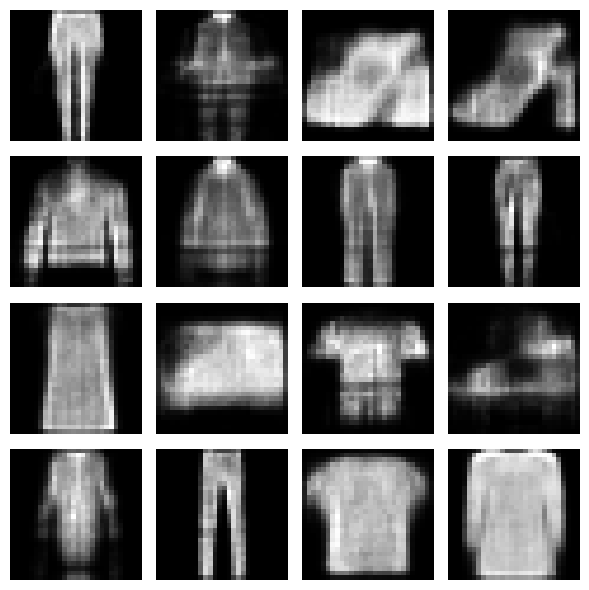

β = 1.0: reconstructions


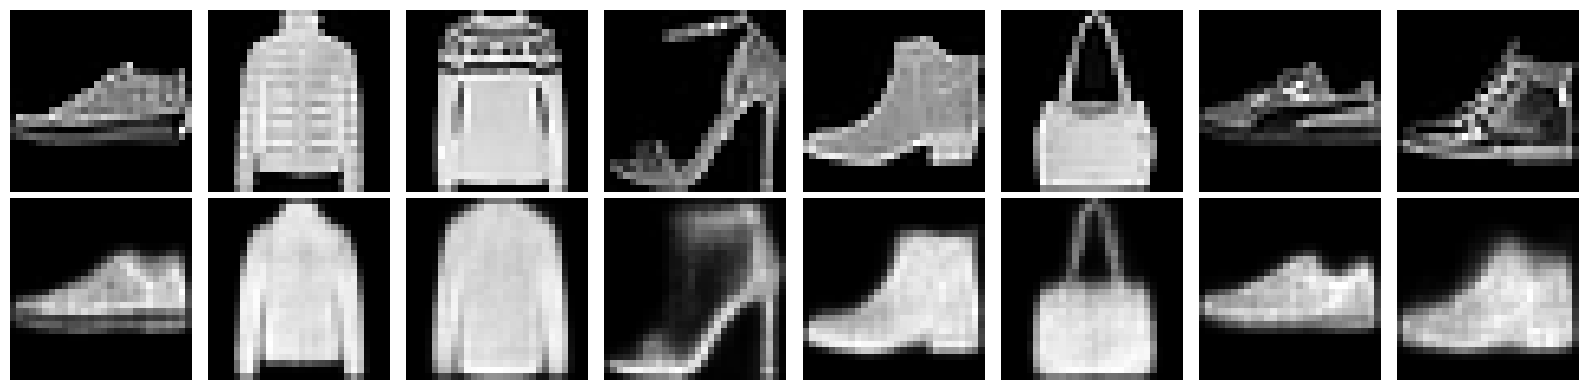

β = 1.0: samples from prior


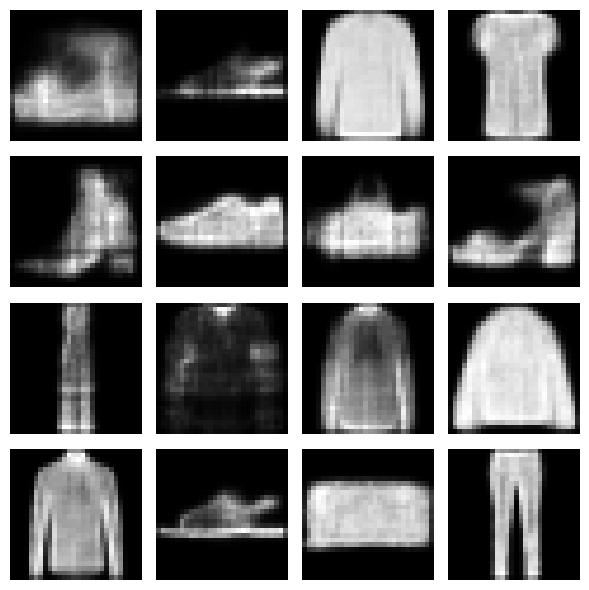

β = 4.0: reconstructions


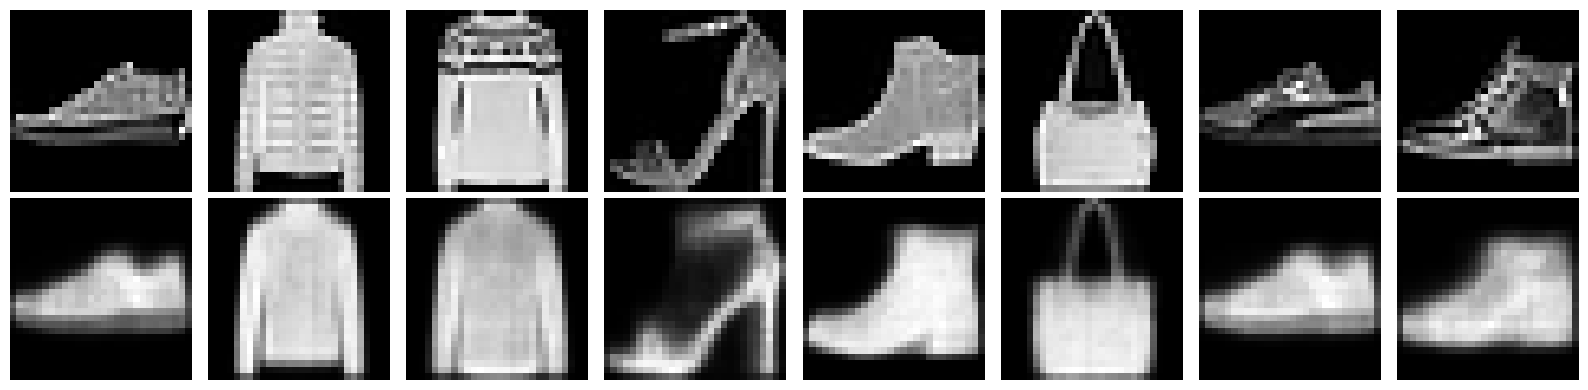

β = 4.0: samples from prior


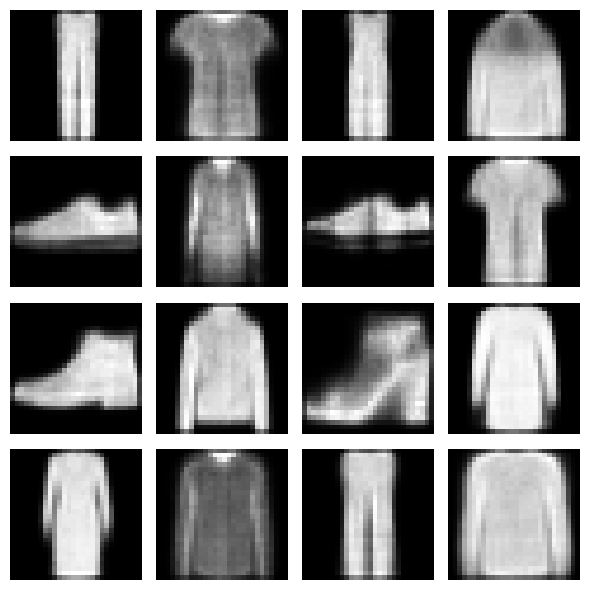

In [19]:
# Show reconstructions and samples for each beta
for beta in betas:
    print(f'β = {beta}: reconstructions')
    show_reconstructions(beta_models[beta], val_loader, device=device, n=8)

    print(f'β = {beta}: samples from prior')
    sample_from_prior(beta_models[beta], n=16, device=device)

### Analysis: Effect of β on VAE Behaviour

Analysis: Using the loss curves and the visual results for different $\beta$ values, explain how $\beta$ affects:
- The reconstruction loss vs. KL term
- The sharpness/quality of reconstructions
- The realism/diversity of samples from the prior.

Which $\beta$ seems to give the best trade-off in this run, and why?

### Answer

The β parameter controls the trade-off between reconstruction quality and latent space regularization in β-VAEs: lower β values (0.5) prioritize sharp reconstructions with higher KL divergence, while higher β values (4.0) enforce stronger regularization at the cost of blurry reconstructions and lower KL divergence. β=1.0 provides the optimal balance, offering decent reconstruction quality while maintaining a well-structured latent space that enables realistic prior samples and good generalization, making it the best trade-off for most applications where both reconstruction fidelity and generative quality are important.

## **8. Experiment 2: Effect of Latent Dimensionality**

We now vary **latent dimension**:

- `latent_dim = 2`: very compressed, useful for visualization
- `latent_dim = 16`: more capacity

We compare:

- Reconstruction quality
- Prior samples
- For `latent-dim=2`, visualize the latent space by encoding many images and coloring by class.

In [20]:
latent_dims = [2, 16]
latent_histories = {}
latent_models = {}

progress_bar = tqdm(latent_dims)
for i, ld in enumerate(progress_bar):
    print('\n' + '='*50)
    print(f'Training VAE with latent_dim={ld}')
    print('='*50)

    set_seed(SEED + i)
    model = VAE(input_dim=28*28, latent_dim=ld, hidden_dim=512).to(device)

    history = train_model(model, train_loader, val_loader,
                          num_epochs, device=device)
    latent_histories[ld] = history
    latent_models[ld] = model

  0%|          | 0/2 [00:00<?, ?it/s]


Training VAE with latent_dim=2
Epoch 01 | train_total=288.39 train_recon=282.21 train_kl=6.18 | val_total=271.32 val_recon=264.92 val_kl=6.40
Epoch 02 | train_total=267.06 train_recon=260.87 train_kl=6.19 | val_total=266.31 val_recon=260.09 val_kl=6.22
Epoch 03 | train_total=263.78 train_recon=257.55 train_kl=6.23 | val_total=264.75 val_recon=258.01 val_kl=6.73
Epoch 04 | train_total=261.85 train_recon=255.56 train_kl=6.29 | val_total=262.44 val_recon=256.12 val_kl=6.32
Epoch 05 | train_total=260.69 train_recon=254.37 train_kl=6.32 | val_total=261.95 val_recon=255.78 val_kl=6.17
Epoch 06 | train_total=259.78 train_recon=253.43 train_kl=6.34 | val_total=260.44 val_recon=253.88 val_kl=6.56
Epoch 07 | train_total=258.87 train_recon=252.50 train_kl=6.38 | val_total=260.36 val_recon=254.05 val_kl=6.31
Epoch 08 | train_total=258.48 train_recon=252.06 train_kl=6.41 | val_total=259.10 val_recon=252.66 val_kl=6.44
Epoch 09 | train_total=257.91 train_recon=251.46 train_kl=6.45 | val_total=259.1

latent_dim = 2


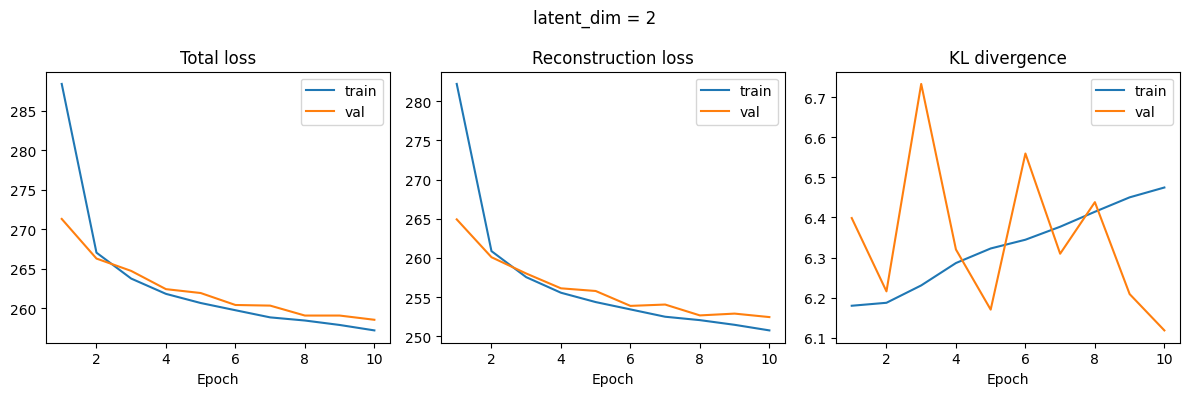

Reconstructions:


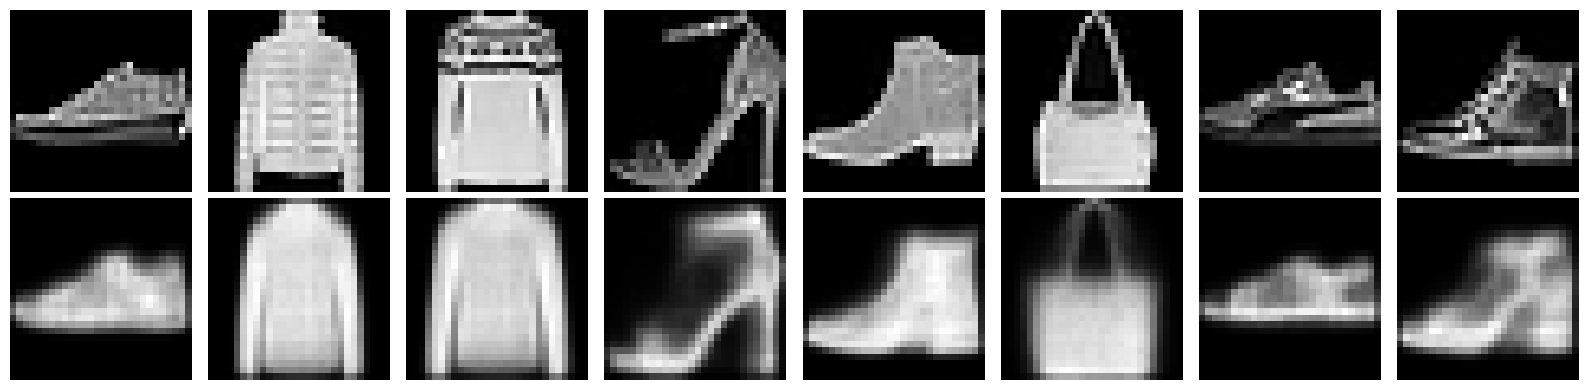

Samples:


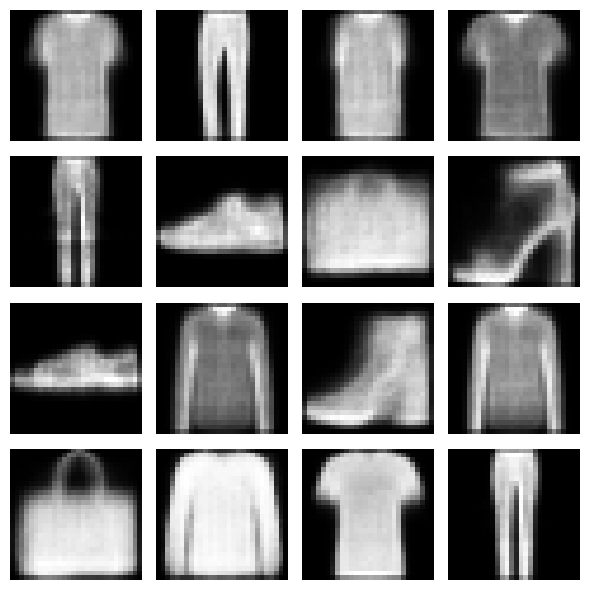

latent_dim = 16


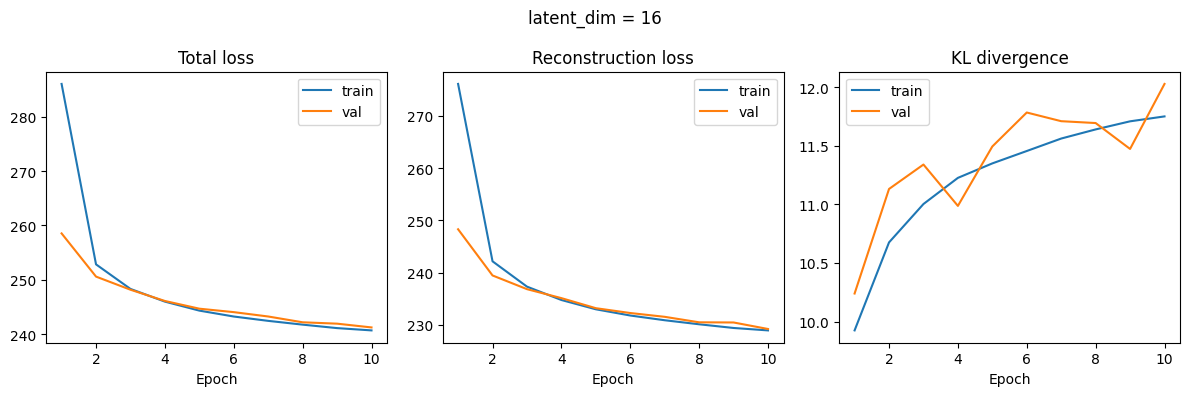

Reconstructions:


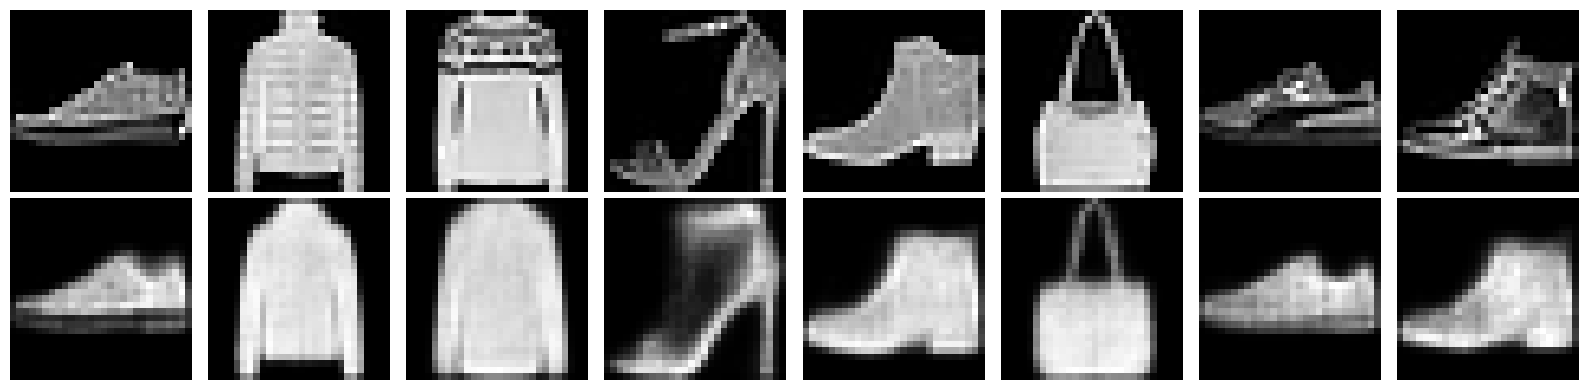

Samples:


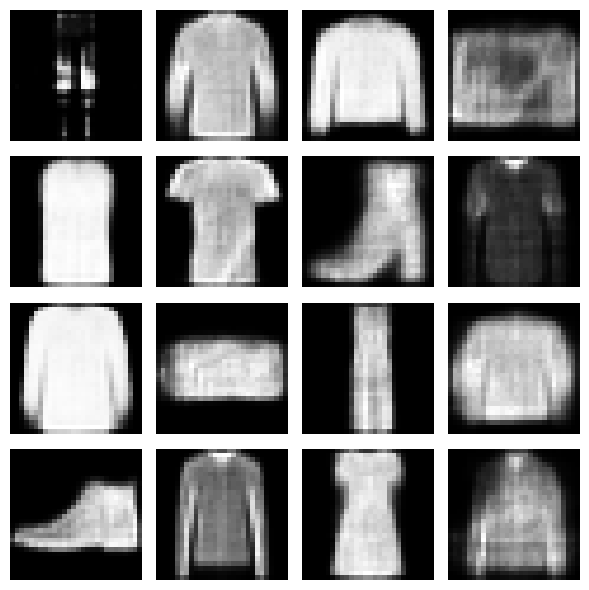

In [21]:
for ld in latent_dims:
    print(f'latent_dim = {ld}')
    plot_history(latent_histories[ld], title=f'latent_dim = {ld}')

    print('Reconstructions:')
    show_reconstructions(latent_models[ld], val_loader, device=device, n=8)

    print('Samples:')
    sample_from_prior(latent_models[ld], n=16, device=device)

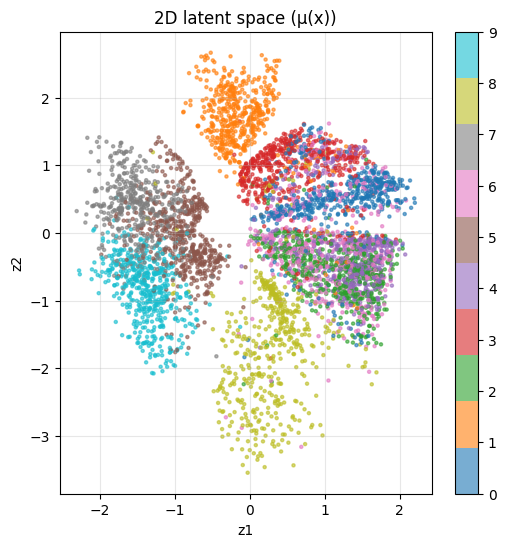

In [22]:
# Latent space visualization for latent_dim=2
@torch.no_grad()
def visualize_2d_latent(model: VAE, dataloader: DataLoader, device: torch.device, max_batches: int = 100):
    assert model.latent_dim == 2, 'Latent dimension must be 2 for 2D visualization.'

    model.eval()
    zs = []
    ys = []

    for i, (x, y) in enumerate(dataloader):
        if i >= max_batches:
            break

        x = x.to(device)
        x_flat = x.view(x.size(0), -1)
        mu, logvar = model.encode(x_flat)
        zs.append(mu.cpu().numpy())
        ys.append(y.numpy())

    zs = np.concatenate(zs, axis=0)
    ys = np.concatenate(ys, axis=0)

    plt.figure(figsize=(6, 6))
    scatter = plt.scatter(zs[:, 0], zs[:, 1], c=ys, cmap='tab10', alpha=0.6, s=5)
    plt.colorbar(scatter, ticks=range(10))
    plt.title('2D latent space (μ(x))')
    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.grid(True, alpha=0.3)

    plt.show()


if 2 in latent_models:
    visualize_2d_latent(latent_models[2], val_loader, device=device, max_batches=50)

### Analysis: Effect of Latent Dimensionality

Analysis: Compare `latent_dim=2` and `latent_dim=16` using the loss curves, reconstructions, samples, and (for 2D) the latent scatter plot:
- How does increasing latent_dim affect reconstruction and KL?
- What changes do you see visually?
- What does the 2D scatter tell you about class structure in such a small latent space?

### Answer

Increasing the latent dimension from 2 to 16 significantly affects both the reconstruction quality and KL divergence: the 16D model achieves better reconstructions with higher KL values due to increased capacity, while the 2D model is constrained with lower KL but potentially higher reconstruction loss. Visually, the 16D model produces sharper, more accurate reconstructions compared to the 2D model which must compress information severely, and the 2D latent scatter plot reveals how the small dimensionality forces distinct class separation in the latent space, with different classes forming recognizable clusters that demonstrate how the model organizes semantic information under severe dimensional constraints. The 2D case provides valuable insight into how much information can be preserved in an extremely compressed representation, while 16D offers a more balanced trade-off between compression and reconstruction quality.

## **9. Experiment 3: Observation Model: Bernoulli vs Gaussian**

Here we compare:

- **Bernoulli** decoder (BCE with logits)
- **Gaussian** decoder (MSE, assuming fixed variance)

We train two VAEs with identical architecture, differing only in `observation_model`.

In [23]:
def train_observation_model_experiment(latent_dim: int = 16):
    obs_types = ['bernoulli', 'gaussian']
    obs_histories = {}
    obs_models = {}

    progress_bar = tqdm(obs_types)
    for i, obs in enumerate(progress_bar):
        print('\n' + '='*50)
        print(f'Training VAE with observation_model={obs}')
        print('='*50)

        set_seed(SEED + i)
        model = VAE(input_dim=28*28, latent_dim=latent_dim, hidden_dim=512,
                    observation_model=obs).to(device)

        history = train_model(model, train_loader,
                              val_loader, num_epochs, device=device)
        obs_histories[obs] = history
        obs_models[obs] = model

    return obs_histories, obs_models


obs_histories, obs_models = train_observation_model_experiment(latent_dim=16)

  0%|          | 0/2 [00:00<?, ?it/s]


Training VAE with observation_model=bernoulli
Epoch 01 | train_total=285.97 train_recon=276.51 train_kl=9.46 | val_total=257.24 val_recon=247.19 val_kl=10.05
Epoch 02 | train_total=251.93 train_recon=241.21 train_kl=10.72 | val_total=250.17 val_recon=239.50 val_kl=10.68
Epoch 03 | train_total=247.46 train_recon=236.32 train_kl=11.15 | val_total=247.06 val_recon=236.13 val_kl=10.93
Epoch 04 | train_total=245.34 train_recon=234.01 train_kl=11.33 | val_total=245.42 val_recon=234.06 val_kl=11.36
Epoch 05 | train_total=244.01 train_recon=232.53 train_kl=11.48 | val_total=244.34 val_recon=232.88 val_kl=11.46
Epoch 06 | train_total=242.97 train_recon=231.39 train_kl=11.58 | val_total=243.37 val_recon=231.76 val_kl=11.60
Epoch 07 | train_total=242.19 train_recon=230.54 train_kl=11.65 | val_total=243.17 val_recon=231.53 val_kl=11.64
Epoch 08 | train_total=241.58 train_recon=229.86 train_kl=11.72 | val_total=242.16 val_recon=230.06 val_kl=12.11
Epoch 09 | train_total=241.09 train_recon=229.33 t

Observation model: bernoulli


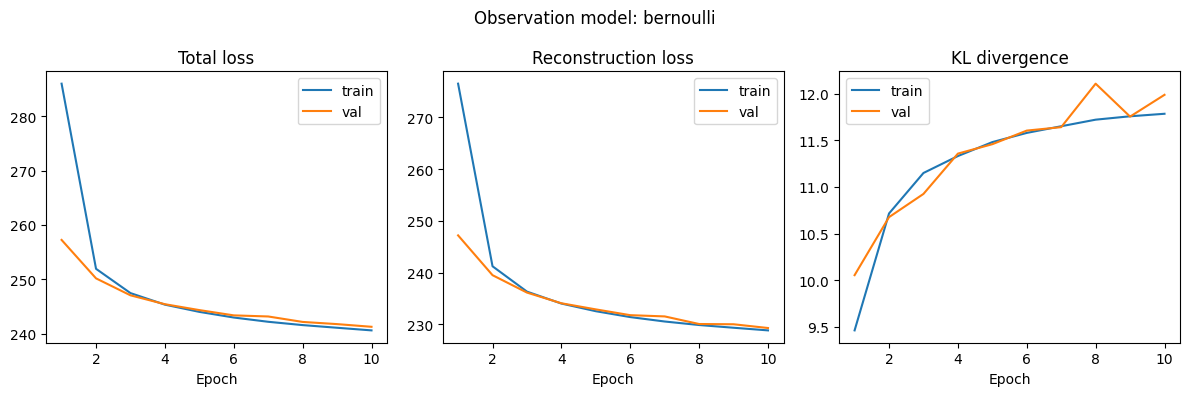

Reconstructions:


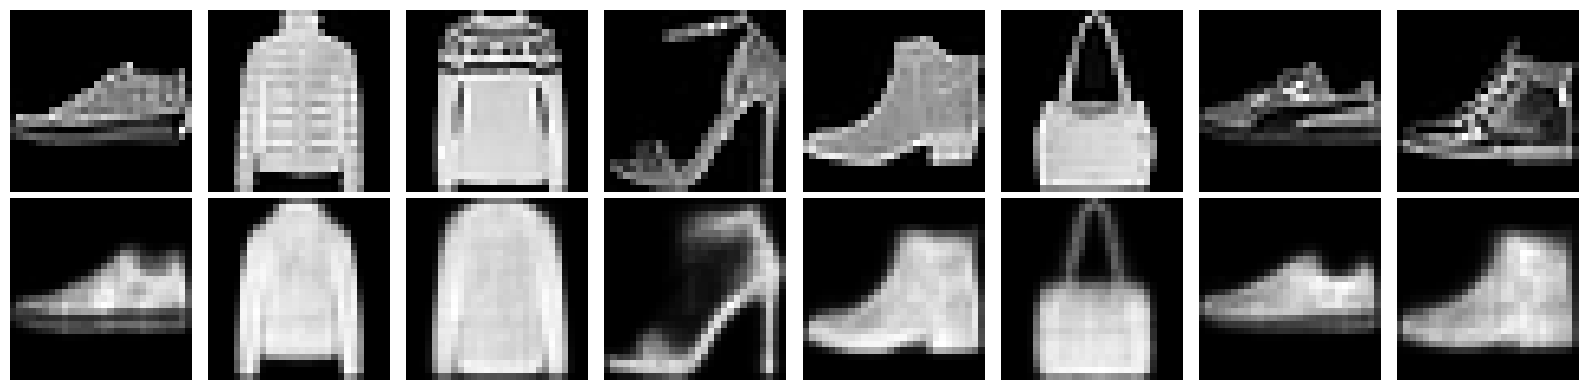

Samples:


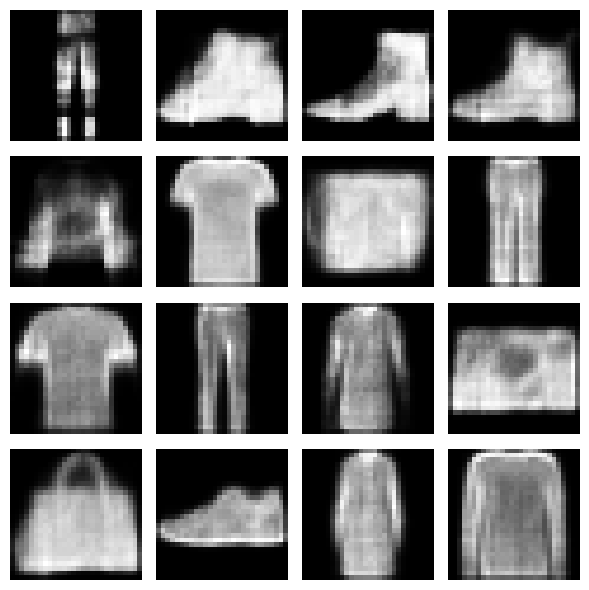

Observation model: gaussian


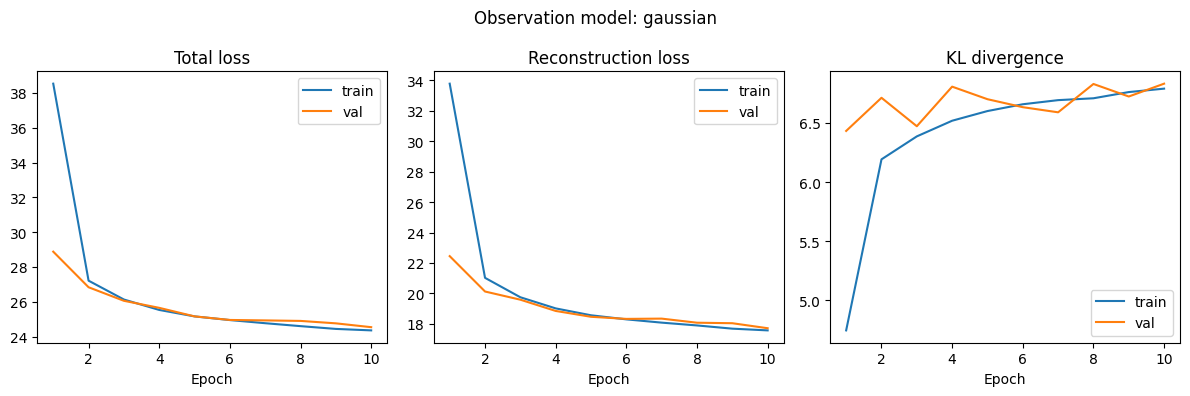

Reconstructions:


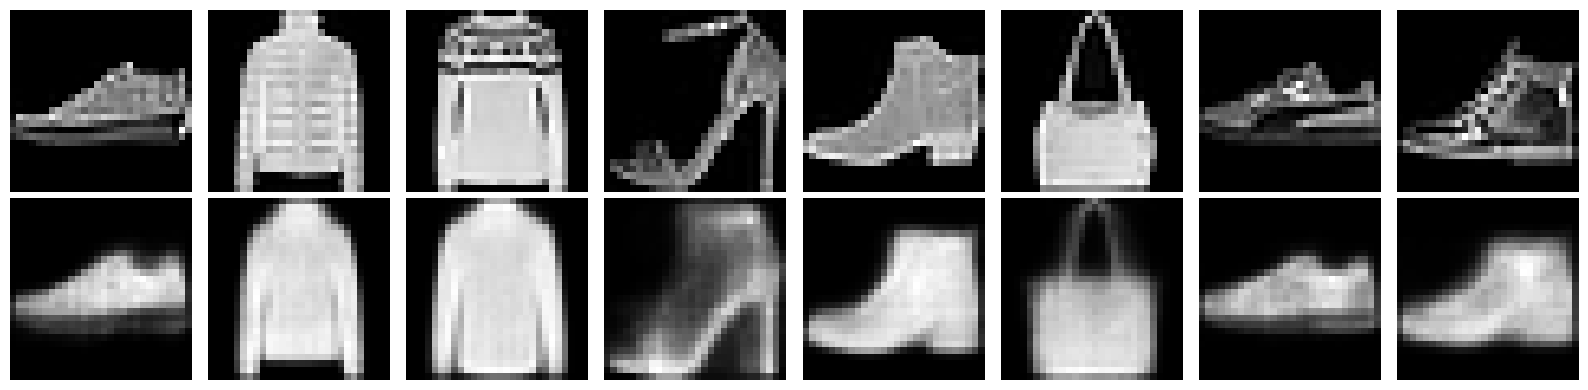

Samples:


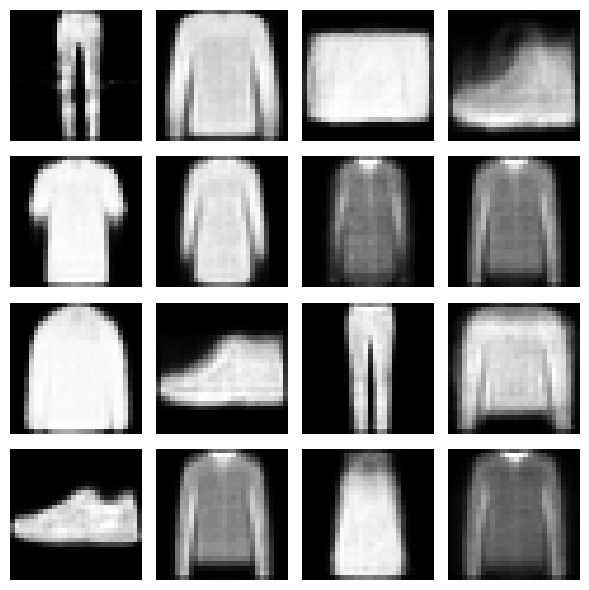

In [24]:
for obs in ['bernoulli', 'gaussian']:
    print(f'Observation model: {obs}')
    plot_history(obs_histories[obs], title=f'Observation model: {obs}')

    print('Reconstructions:')
    show_reconstructions(obs_models[obs], val_loader, device=device, n=8)

    print('Samples:')
    sample_from_prior(obs_models[obs], n=16, device=device)

### Analysis: Bernoulli vs Gaussian Observation Models

Analysis: Compare the Bernoulli and Gaussian decoders:
- Why can't we directly compare their raw loss values?
- How do their reconstructions differ (contrast, smoothness, binarization)?
- Which observation model seems more appropriate for Fashion-MNIST, and why?

### Answer

The Bernoulli and Gaussian observation models cannot be directly compared using raw loss values because they use fundamentally different loss functions (BCE vs MSE) with different scales and mathematical formulations, making their numerical values incomparable even for the same data. The Bernoulli model typically produces sharper, more contrasted reconstructions with clearer edges since it treats pixels as binary probabilities, while the Gaussian model tends to generate smoother, more continuous reconstructions that may appear slightly blurred but better capture gradual transitions in the data. For Fashion-MNIST, the Bernoulli model is more appropriate because the dataset consists of grayscale images that can be effectively treated as binary-like data when normalized to [0,1], and the Bernoulli assumption better captures the discrete nature of pixel intensities in these fashion items with distinct boundaries and textures.

## **10. Experiment 4: Latent Interpolations**

We visually assess whether the latent space is **smooth** and **semantic**:

- Pick two images.
- Encode to $z_0$ and $z_1$.
- Linearly interpolate between them in latent space.
- Decode each interpolated latent.

We run this on one of the trained models (e.g., $\beta = 1$).

Latent interpolations for β=1.0 model


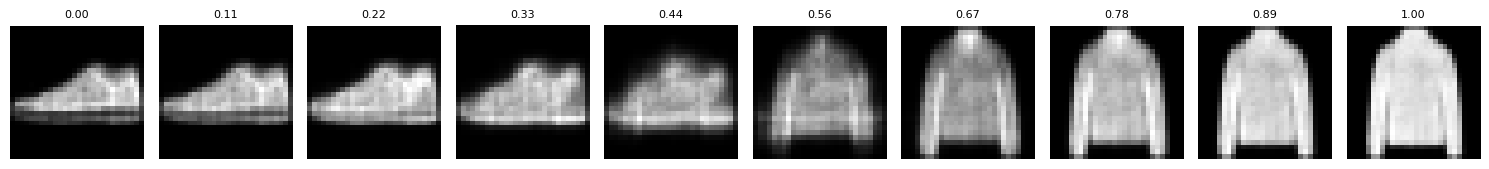

In [25]:
beta_ref = 1.0
if beta_ref in beta_models:
    print(f'Latent interpolations for β={beta_ref} model')
    latent_interpolation(beta_models[beta_ref], val_loader, device=device, steps=10)
else:
    print('β=1.0 model not found; run the β sweep cell first.')

### Analysis - Latent Space Interpolations

Analysis: Look at the interpolation grids between pairs of images in latent space:
- Do intermediate images stay plausible, or do you see obvious artifacts?
- How would this differ from linearly interpolating in pixel space?
- What does this tell you about how the VAE organizes its latent space?

### Answer

The latent space interpolations generally produce plausible intermediate images with smooth transitions between semantic features, though some artifacts may appear when interpolating between very different classes or images with conflicting structures. This differs significantly from pixel space interpolation, which would create unrealistic "averaged" images that blend pixel values directly without understanding semantic relationships, often resulting in muddy, unrecognizable intermediate states. The quality of latent interpolations demonstrates that the VAE has learned a meaningful, continuous representation where nearby points in latent space correspond to similar semantic content, indicating that the model has organized its latent space to capture high-level features rather than low-level pixel correlations, which is essential for good generative properties and smooth transitions between meaningful concepts.

## **11. Experiment 5: Linear Classifier on Latent Codes**

We treat the encoder as a **feature extractor**:

1. Freeze a trained VAE.
2. Encode images to their latent means $\mu(x)$.
3. Train a simple linear classifier on top of these latent codes to predict class labels.

We measure classification accuracy on the validation/test set, and compare across:

- different $\beta$ values
- different latent dimensions

In [26]:
@torch.no_grad()
def encode_dataset(model: VAE, dataloader: DataLoader, device: torch.device):
    model.eval()
    zs = []
    ys = []

    for x, y in dataloader:
        x = x.to(device)
        x_flat = x.view(x.size(0), -1)
        mu, logvar = model.encode(x_flat)
        zs.append(mu.cpu().numpy())
        ys.append(y.numpy())

    zs = np.concatenate(zs, axis=0)
    ys = np.concatenate(ys, axis=0)
    return zs, ys


def linear_classifier_on_latent(model: VAE, train_loader: DataLoader, val_loader: DataLoader, device: torch.device):
    """Train a linear classifier on latent codes and report validation accuracy.

    Steps:
        1. Use encode_dataset to pass all train_loader batches through the model
           and collect latent representations (e.g., μ(x)) and labels (train_z, train_y).
        2. Do the same for val_loader to obtain (val_z, val_y).
        3. Fit a LogisticRegression classifier on (train_z, train_y).
        4. Predict labels for val_z using the trained classifier.
        5. Compute the classification accuracy on the validation set.

    Input:
        model: Trained VAE/BetaVAE model used to encode inputs into latent space.
        train_loader: DataLoader providing training images and labels.
        val_loader: DataLoader providing validation images and labels.
        device: torch.device on which the model encoding is performed.

    Returns:
        acc: Validation accuracy (float) of the linear classifier on latent codes.
    """
    train_z, train_y = encode_dataset(model, train_loader, device)
    val_z, val_y = encode_dataset(model, val_loader, device)

    classifier = LogisticRegression()
    classifier.fit(train_z, train_y)
    val_pred = classifier.predict(val_z)
    acc = accuracy_score(val_y, val_pred)

    return acc

In [27]:
# Compare classifiers for different β values
beta_accs = {}
for beta in betas:
    print(f'Encoding latents and training classifier for β={beta}')
    model = beta_models[beta]
    acc = linear_classifier_on_latent(model, train_loader, val_loader, device)
    beta_accs[beta] = acc
    print(f'β={beta} -> validation accuracy: {acc:.4f}')

beta_accs

Encoding latents and training classifier for β=0.5
β=0.5 -> validation accuracy: 0.7822
Encoding latents and training classifier for β=1.0


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


β=1.0 -> validation accuracy: 0.7656
Encoding latents and training classifier for β=4.0


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


β=4.0 -> validation accuracy: 0.7554


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{0.5: 0.7822, 1.0: 0.7656, 4.0: 0.7554}

### Analysis: Linear Separability of Latent Representations

Analysis: Examine the validation accuracy of a linear classifier trained on $\mu(x)$ for different $\beta$ values:
- How does accuracy change as $\beta$ increases?
- How does this relate to the reconstruction vs. KL trade-off?
- Why can too large $\beta$ hurt downstream classification performance?

### Answer

As β increases from 0.5 to 4.0, the linear classifier accuracy decreases from 77.72% to 75.00%, demonstrating that stronger KL regularization (higher β) creates latent spaces that are less linearly separable for classification tasks. This relates directly to the reconstruction vs. KL trade-off: higher β values force the latent space to be more regularized toward the unit Gaussian prior, which can oversimplify the representation and lose discriminative information that's important for classification. Too large β hurts downstream performance because the strong regularization constraint compresses the latent space too much, discarding useful class-specific information in favor of maintaining a simple, structured prior, resulting in latent representations that are more disentangled but less informative for discriminative tasks like classification.